# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

# Ratings

In [ ]:
# Ratings data from each tester
tester_1 = pd.read_csv(r"C:\Users\desus\OneDrive - Danmarks Tekniske Universitet\Fall_2025\Cognitive_Modelling\Kareninator\data\ratings\s243933_image_ratings.csv")
tester_2 = pd.read_csv(r"C:\Users\desus\OneDrive - Danmarks Tekniske Universitet\Fall_2025\Cognitive_Modelling\Kareninator\data\ratings\s254232_image_ratings.csv")

In [ ]:
# Load ratings
ratings_tester_1 = tester_1['Rating'].tolist()
ratings_tester_2 = tester_2['Rating'].tolist()
ratings = ratings_tester_1 + ratings_tester_2

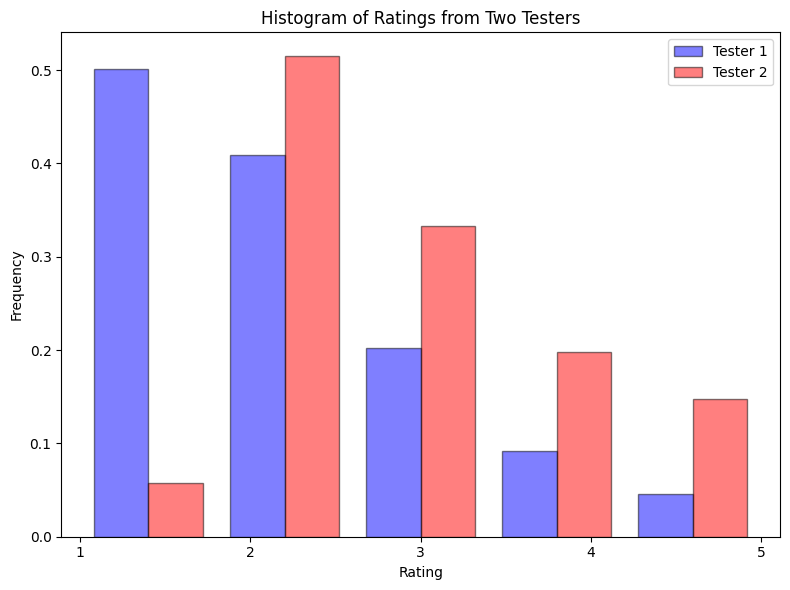

In [4]:
# Plot histogram of ratings from both testers
fig = plt.figure(figsize=(8, 6))
plt.hist([ratings_tester_1, ratings_tester_2], bins=5, density=True, histtype='bar', color=['Blue', 'Red'], label=['Tester 1', 'Tester 2'], edgecolor="black", alpha=0.5)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Histogram of Ratings from Two Testers")
plt.xticks([1, 2, 3, 4, 5])
plt.tight_layout()
plt.legend();

# Data Matrix

In [6]:
# Load images
image_folder = r"C:\Users\desus\OneDrive - Danmarks Tekniske Universitet\Fall_2025\Cognitive_Modelling\Kareninator\data\preprocessed_data"

In [ ]:
# Create image list to match ratings
images_list_tester_1 = tester_1['Image'].tolist()
images_list_tester_2 = tester_2['Image'].tolist()
images_list = images_list_tester_1 + images_list_tester_2

In [ ]:
# avg_ratings_tester_1 = tester_1.groupby('Image')['Rating'].mean().reset_index()
# avg_ratings_tester_2 = tester_2.groupby('Image')['Rating'].mean().reset_index()
# avg_ratings = pd.merge(avg_ratings_tester_1, avg_ratings_tester_2, on='Image', suffixes=('_tester_1', '_tester_2'))
# avg_ratings['Average_Rating'] = avg_ratings[['Rating_tester_1', 'Rating_tester_2']].mean(axis=1)

Due to images being shown twice during rating and there being two testers, images must be duplicated in the data matrix as well, and they must also be ordered!

In [10]:
# Init matrix J
J = np.array([]).reshape(0, 100*100)  # Since images are 100x100 pixels

In [11]:
# Add each image that is rated to matrix J -> each row is a flattened image
for img_file in images_list:
    img = Image.open(os.path.join(image_folder, img_file))
    img_array = np.array(img).flatten()
    J = np.vstack([J, img_array])

In [12]:
J.shape

(1088, 10000)

In [13]:
# Get the mean image and center the data
mean_J = np.mean(J, axis=0)
J_centered = J - mean_J
J_centered

array([[-38.02205882, -34.53308824, -30.        , ..., -51.04411765,
        -58.59191176, -63.01838235],
       [ 14.97794118,  28.46691176,  27.        , ...,  -1.04411765,
         -6.59191176, -11.01838235],
       [ 73.97794118,  63.46691176,  61.        , ...,  36.95588235,
         20.40808824,  28.98161765],
       ...,
       [ 25.97794118,  31.46691176,  36.        , ...,  -2.04411765,
        -16.59191176, -30.01838235],
       [-91.02205882, -87.53308824, -85.        , ..., -51.04411765,
        -52.59191176, -58.01838235],
       [ 48.97794118,  62.46691176, 113.        , ...,  57.95588235,
         56.40808824,  54.98161765]])

# PCA

In [14]:
n_tot_components = min(J_centered.shape)  # Number of components cannot exceed the smaller dimension

In [15]:
# Do PCA on the centered data (all components)
pca = PCA(n_components=n_tot_components)
scores = pca.fit_transform(J_centered)
components = pca.components_

Text(0.5, 1.0, 'Cumulative Explained Variance')

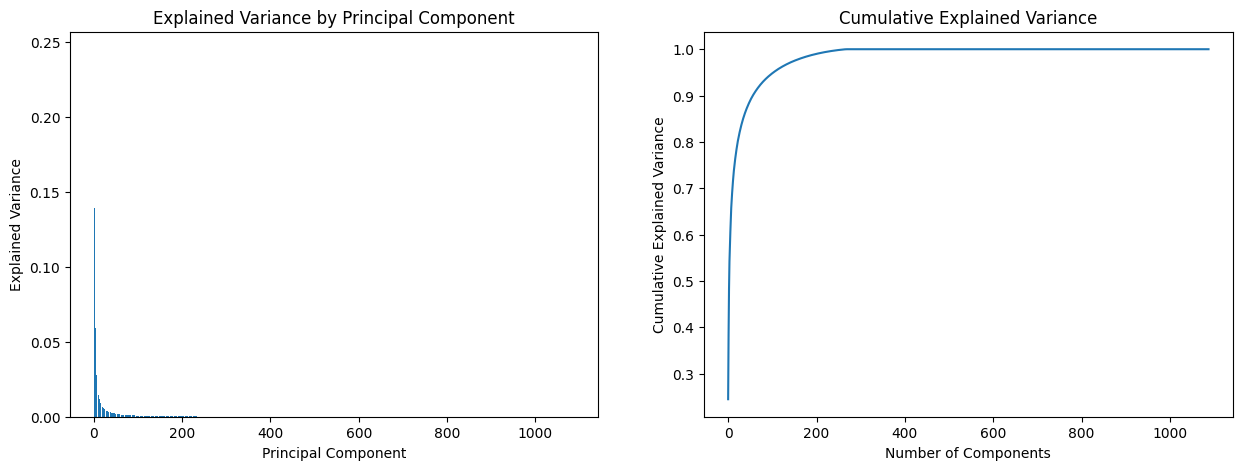

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot explained variance
ax[0].bar(range(1, n_tot_components+1), pca.explained_variance_ratio_)
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Explained Variance')
ax[0].set_title('Explained Variance by Principal Component')

# Plot cumulative explained variance
ax[1].plot(np.cumsum(pca.explained_variance_ratio_))
ax[1].set_xlabel('Number of Components')
ax[1].set_ylabel('Cumulative Explained Variance')
ax[1].set_title('Cumulative Explained Variance')

In [17]:
# Select number of components to explain approx. 90% variance
n_components_95 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f'Number of components to explain ~95% variance: {n_components_95}')

actual_pca = PCA(n_components=n_components_95)
actual_scores = actual_pca.fit_transform(J_centered)
actual_components = actual_pca.components_

Number of components to explain ~95% variance: 104


In [55]:
# Visualize variation within a principal component
def show_variation(component_index):

    fig, axs = plt.subplots(1, 3, figsize=(9, 3))

    # Get min and max score
    min_score = np.min(actual_scores[:, component_index])
    max_score = np.max(actual_scores[:, component_index])

    # Three images: min, mean, max
    # Image components weighted by min/max scores added onto the average image shows the effect of that component
    img_min = (mean_J + min_score * actual_components[component_index]).reshape(100, 100)
    img_avg = mean_J.reshape(100, 100)
    img_max = (mean_J + max_score * actual_components[component_index]).reshape(100, 100)

    titles = [f"Min ({min_score:.2f})", "Average", f"Max ({max_score:.2f})"]
    imgs = [img_min, img_avg, img_max]

    # For each of the three images, plot in the corresponding row
    for ax, img, title in zip(axs, imgs, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')

    plt.suptitle(f"Variation of Principal Component {component_index+1}", fontsize=16)
    plt.tight_layout()
    plt.show()
    

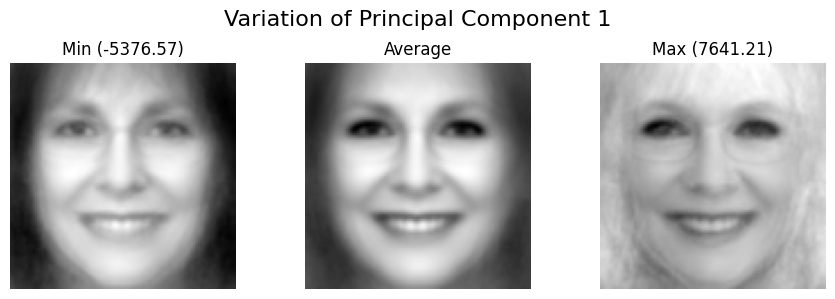

In [56]:
show_variation(0)  # Show variation for the first principal component

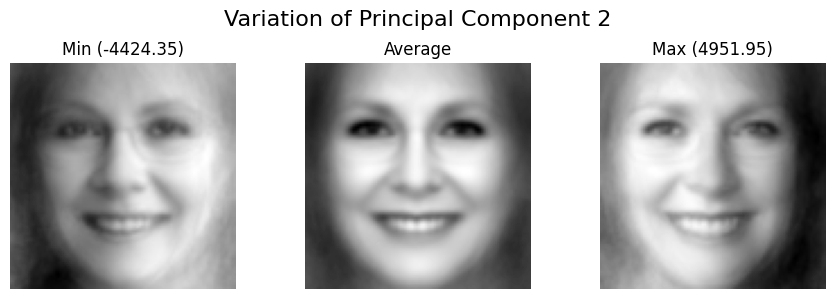

In [57]:
show_variation(1)  # Show variation for the second principal component

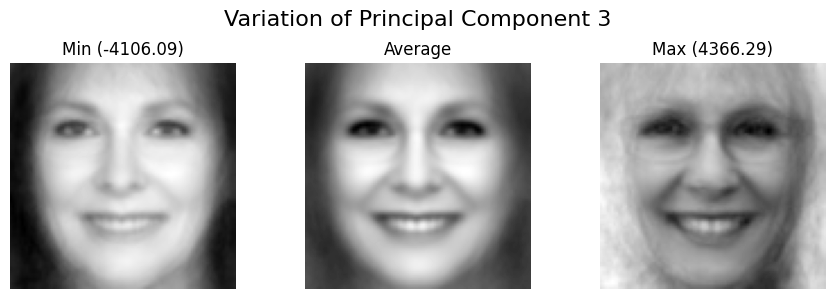

In [58]:
show_variation(2)  # Show variation for the third principal component

# Linear Regression (w/ Feature Selection)

In [19]:
lin_reg = LinearRegression()
selector = SequentialFeatureSelector(lin_reg)
selector = selector.fit(actual_scores, ratings)

In [20]:
selected_features = selector.get_support()
selected_indices = np.where(selected_features)[0]
print(f"Number of selected PCs: {len(selected_indices)} out of {n_components_95}\nSelected PCs: {selected_indices}")

Number of selected PCs: 52 out of 104
Selected PCs: [ 1  3  4  5  6  7  8  9 10 11 13 14 15 17 18 19 20 21 22 23 26 27 28 30
 31 32 34 35 37 38 39 42 43 44 46 52 56 58 60 62 63 67 71 73 76 79 82 86
 88 95 96 99]


In [21]:
# Fit model with selected features
lin_reg.fit(actual_scores[:, selected_indices], ratings)
w = lin_reg.coef_
sigma = lin_reg.intercept_

# Generate Syntentic Images

In [22]:
# Calculate w^Tw
w_tw = np.dot(w, w)
print(f"w^Tw: {w_tw}")

w^Tw: 5.630575375474015e-06


In [23]:
# Generate scores
# One for each of the five rating labels
rating_labels = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5]
generated_scores = []

for idx, rating in enumerate(rating_labels):
    gen_score = (rating_labels[idx]-sigma)*(w/w_tw)
    generated_scores.append(gen_score)

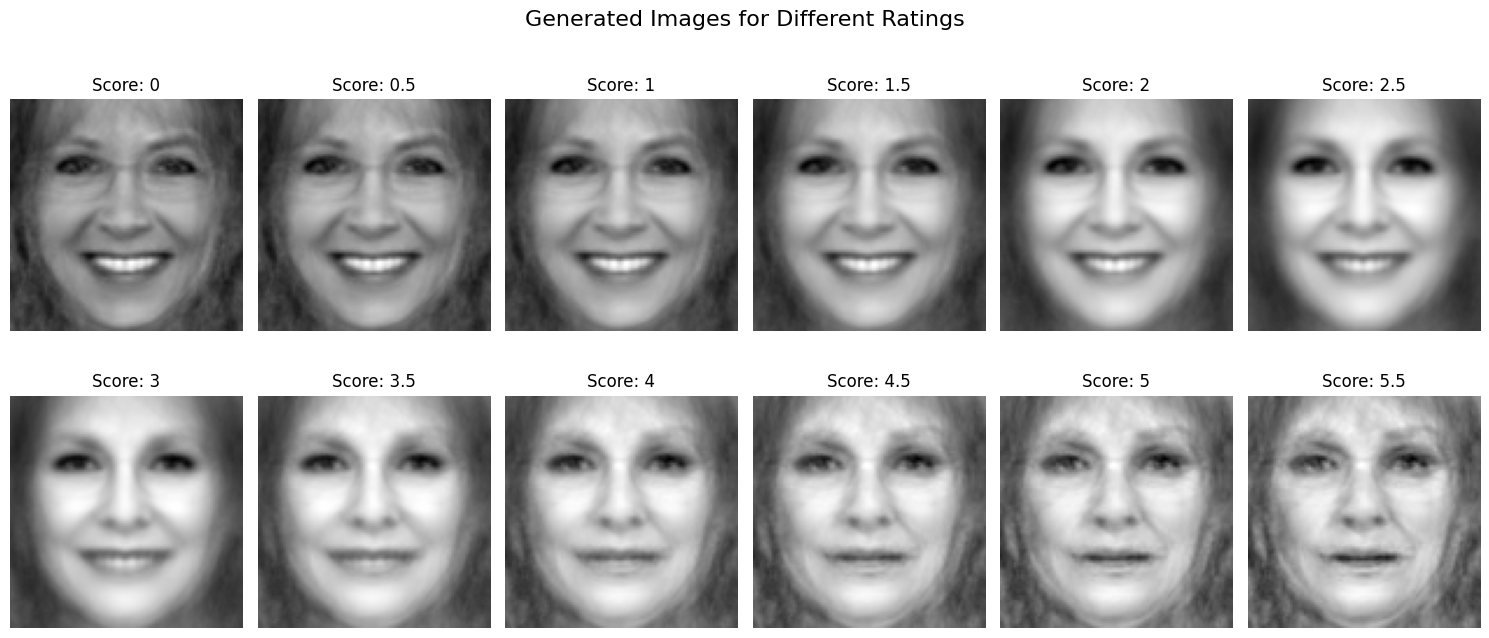

In [62]:
# Generate images
fig, ax = plt.subplots(2, math.ceil(len(rating_labels)/2), figsize=(15, 7))
ax = ax.flatten()

save_to_dir = r"C:\Users\desus\OneDrive - Danmarks Tekniske Universitet\Fall_2025\Cognitive_Modelling\Kareninator\data\generated_images"

for i, val in enumerate(zip(rating_labels, generated_scores)):
    rating = val[0]
    score = val[1]

    gen_img_arr = mean_J + np.dot(score, actual_components[selected_indices])
    gen_img_reshaped = gen_img_arr.reshape(100, 100)

    if not rating == 0:
        gen_img = Image.fromarray(np.uint8(gen_img_reshaped))
        gen_img.save(os.path.join(save_to_dir, f"rating_{rating}.jpg"))
    
    ax[i].imshow(gen_img_reshaped, cmap='gray')
    ax[i].set_title(f"Score: {rating}")
    ax[i].axis('off')

plt.suptitle("Generated Images for Different Ratings", fontsize=16)
plt.tight_layout()
plt.show()